In [6]:
folder = "D:\\VSCODE\\EmotionsRecognition\\"

# Thư viện

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import re
import copy
import gensim
import emoji
import joblib
from pyvi import ViTokenizer, ViPosTagger
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [24]:
train = pd.read_excel(r'../Data/train.xlsx', index_col=0)
test = pd.read_excel(r'../Data/test.xlsx', index_col=0)

In [25]:
train

,Emotion,Sentence
188,Other,cho mình xin bài nhạc tên là gì với ạ
166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...
316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :))
1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...
...,...,...
1332,Disgust,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...
825,Other,nhìn mặt héo queo luôn
165,Other,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...
363,Enjoyment,thích thân hình boss rồi nhan 😌


In [26]:
stopwords = []
with open('../Data/vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())
# stopwords

In [27]:
teencodes = {}
with open('../Data/teencode4.txt','r',encoding='utf-8') as file:
    file = file.read()
    lines = file.split('\n')
    for line in lines:
        elements = line.split('\t')
        if len(elements) == 2:
            teencodes[elements[0]] = elements[1]
# teencodes

In [28]:
def preprocess_teencodes(sentence):
    for key, value in teencodes.items():
        sentence = re.sub(r'\b{}\b'.format(key), value, sentence)
    return sentence

In [29]:
def preprocess_emoji(sentence):
    emotion_dict = {
        '(:|;|=)+(\)|\]|>)+':'🙂','(:|;|=)+(\(|\[|<)+':'😞','(:|;|=)+(D|d)':'😁',
        '(-_-)|(-\.-)':'😐',':v':'_pacman_smile_','(:|;|=)+(\'|`|\")+(\)|\]|>)+':'🥲','(:|;|=)+(\'|`|\")+(\(|\[|<)+':'😢',
        '@@':'😵‍💫','đc':'được','đk':'được','bik':'biết','ngừi':'người','hix':'hic','lm':'làm'
    }
    for key, value in emotion_dict.items():
        sentence = re.sub(key,value,sentence)
    sentence = emoji.demojize(sentence)
    sentence = re.sub(r":(.*?):",r" _\1_ ",sentence)
    sentence = re.sub(r'([!@#$%^&*()_+={}:;"\'<>,?/\|~-])\1+',r'\1',sentence)
    return sentence

<>:3: SyntaxWarning: invalid escape sequence '\)'
<>:3: SyntaxWarning: invalid escape sequence '\('
<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\)'
<>:4: SyntaxWarning: invalid escape sequence '\('
<>:3: SyntaxWarning: invalid escape sequence '\)'
<>:3: SyntaxWarning: invalid escape sequence '\('
<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\)'
<>:4: SyntaxWarning: invalid escape sequence '\('
C:\Users\vanhu\AppData\Local\Temp\ipykernel_18924\1970431461.py:3: SyntaxWarning: invalid escape sequence '\)'
  '(:|;|=)+(\)|\]|>)+':'🙂','(:|;|=)+(\(|\[|<)+':'😞','(:|;|=)+(D|d)':'😁',
C:\Users\vanhu\AppData\Local\Temp\ipykernel_18924\1970431461.py:3: SyntaxWarning: invalid escape sequence '\('
  '(:|;|=)+(\)|\]|>)+':'🙂','(:|;|=)+(\(|\[|<)+':'😞','(:|;|=)+(D|d)':'😁',
C:\Users\vanhu\AppData\Local\Temp\ipykernel_18924\1970431461.py:4: SyntaxWarning: invalid escape sequence '\.'
  '(-_-)|(-\.-)':'😐',

In [30]:
def tokenize(sentence):
    start_token = ' _s_ '
    end_token = ' _e_ '
    sentence = sentence.lower()

    # Preprocess Emoji
    sentence = preprocess_emoji(sentence)

    # Preprocess teencodes
    sentence = preprocess_teencodes(sentence)

    sentence = start_token + sentence + end_token
    return ViTokenizer.tokenize(sentence).split()

In [31]:
def remove_stopwords(words):
    new_words = [word for word in words if re.sub("_", " ", word) not in stopwords]
    return new_words

In [32]:
train['Text'] = train['Sentence'].apply(tokenize)
train['Text'] = train['Text'].apply(remove_stopwords)
train

,Emotion,Sentence,Text
188,Other,cho mình xin bài nhạc tên là gì với ạ,"[_s_, nhạc, _e_]"
166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,"[_s_, đáng_đời, quỷ, ., lôi, mày, đánh, _enrag..."
1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...,"[_s_, lo, học, đi, ., yêu_đương, lồn, học_sinh..."
316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :)),"[_s_, uớc, già, cụ, _slightly_smiling_face_, _e_]"
1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...,"[_s_, video, coi, đi, coi, hoài, ., cưng, ., _e_]"
...,...,...,...
1332,Disgust,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...,"[_s_, đường, nhà_cụ, cụ, cấm, người_ta, đỗ, .,..."
825,Other,nhìn mặt héo queo luôn,"[_s_, mặt, héo, queo, _e_]"
165,Other,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...,"[_s_, tao, đi, xe_máy, xe, đi, phi_mẹ, quán, n..."
363,Enjoyment,thích thân hình boss rồi nhan 😌,"[_s_, thân_hình, boss, nhan, _relieved_face_, ..."


In [33]:
test['Text'] = test['Sentence'].apply(tokenize)
test['Text'] = test['Text'].apply(remove_stopwords)
test

,Emotion,Sentence,Text
713,Sadness,người ta có bạn bè nhìn vui thật,"[_s_, người_ta, bạn_bè, vui, _e_]"
1827,Surprise,cho nghỉ viêc mói đúng sao goi là kỷ luật,"[_s_, nghỉ, viêc, mói, goi, kỷ_luật, _e_]"
1166,Disgust,kinh vãi 😡,"[_s_, kinh, vãi, _enraged_face_, _e_]"
228,Fear,nhà thì không xa lắm nhưng chưa bao giờ đi vì ...,"[_s_, lắm, đi, sợ, đè_bẹp, _slightly_smiling_f..."
1942,Anger,bố không thích nộp đấy mày thích ý kiến không,"[_s_, bố, nộp, đấy, mày, ý_kiến, _e_]"
...,...,...,...
432,Sadness,lúc thì cuốc đất è cổ ra không có giun mà câu ...,"[_s_, cuốc, đất, è_cổ, giun, câu, cá, _unamuse..."
178,Enjoyment,các bác dẫn crush qua cây sữa nay mà hứng nước...,"[_s_, crush, sữa, hứng, nước_đái, ve_nha, haha..."
1863,Surprise,vợ chồng rồi mà trong sáng như này chỉ có tron...,"[_s_, vợ_chồng, trong_sáng, phim, _face_with_t..."
476,Other,bep này vào binh dương dùng xuất,"[_s_, bep, binh, dương, xuất, _e_]"


Mã hóa cột Emotion của tập train và tập test sang kiểu số

In [34]:
emotions = ['Surprise', 'Sadness', 'Anger', 'Fear', 'Enjoyment', 'Disgust', 'Other']
emotion_to_num = dict({v:k for k,v in enumerate(emotions)})
num_to_emotion = dict({k:v for k,v in enumerate(emotions)})

In [35]:
train['Emotion'] = train['Emotion'].apply(lambda x: emotion_to_num[x])
test['Emotion'] = test['Emotion'].apply(lambda x: emotion_to_num[x])

In [36]:
emotion_to_num

{'Surprise': 0,
 'Sadness': 1,
 'Anger': 2,
 'Fear': 3,
 'Enjoyment': 4,
 'Disgust': 5,
 'Other': 6}

## Data augmentation: các từ ngẫu nhiên trong câu bị thay thế bằng một thẻ đặc biệt (unknown_tag)

In [37]:
def createUnknownData(df,unknown_rate,unknown_tag ='_unk_'):
    mask_df = pd.DataFrame(columns=['Emotion','Text'])
    for row in df.iterrows():
        mask_array = np.random.choice(
            [1,0],size=len(row[1]['Text']),p=[unknown_rate,1-unknown_rate]
        )
        mask_array[0]=0
        mask_array[-1]=0
        if np.sum(mask_array) > 0:
            sentence = copy.deepcopy(row[1]['Text'])
            for idx in range(len(row[1]['Text'])):
                if mask_array[idx] == 1: sentence[idx] = unknown_tag
            mask_df.loc[len(mask_df.index)] = [copy.deepcopy(row[1]['Emotion']),sentence]
    return mask_df

In [38]:
unk_frame = createUnknownData(train,unknown_rate=0.01,unknown_tag ='_unk_')
unk_frame

,Emotion,Text
0,2,"[_s_, thằng, kia, mày, bắt, vợ, bồ, _unk_, dọn..."
1,4,"[_s_, yêu, _unk_, đi, ., _e_]"
2,3,"[_s_, đầu, chụp, 10, huhu, sợ, _loudly_crying_..."
3,6,"[_s_, bồi_thường, thiệt_hại, _unk_, thân, tàu,..."
4,1,"[_s_, haizzz, ..., kết_quả, tốt_đẹp, _unk_, .,..."
...,...,...
350,6,"[_s_, con_gái, bữa, cơm, ,, du, rú, phòng, bố,..."
351,4,"[_s_, per, câu_chuyện, _unk_, trọn, tình, _fac..."
352,5,"[_s_, _unk_, hả, gái, _e_]"
353,2,"[_s_, già, đấy, mấy, mõm, vỡ, _unk_, chó, _e_]"


In [39]:
new_train_frame = pd.concat([train[['Emotion', 'Text']], unk_frame])
new_train_frame

,Emotion,Text
188,6,"[_s_, nhạc, _e_]"
166,5,"[_s_, đáng_đời, quỷ, ., lôi, mày, đánh, _enrag..."
1345,5,"[_s_, lo, học, đi, ., yêu_đương, lồn, học_sinh..."
316,4,"[_s_, uớc, già, cụ, _slightly_smiling_face_, _e_]"
1225,4,"[_s_, video, coi, đi, coi, hoài, ., cưng, ., _e_]"
...,...,...
350,6,"[_s_, con_gái, bữa, cơm, ,, du, rú, phòng, bố,..."
351,4,"[_s_, per, câu_chuyện, _unk_, trọn, tình, _fac..."
352,5,"[_s_, _unk_, hả, gái, _e_]"
353,2,"[_s_, già, đấy, mấy, mõm, vỡ, _unk_, chó, _e_]"


corpus: danh sách các câu, mỗi câu là một danh sách các từ (đã được xử lý trước như loại bỏ dấu câu, chuyển chữ thường, tách từ)

In [40]:
corpus = []
for sentence in new_train_frame['Text']:
  corpus.append(sentence)
len(corpus)

5903

In [41]:
start_token = '_s_'
end_token = '_e_'
unknown_token = '_unk_'

## Balance data - Xử lý dữ liệu mất cân bằng

Phương pháp random undersampling: Giảm tỷ lệ mẫu dữ liệu thuộc một cảm xúc cụ thể trong tập huấn luyện (train) và sau đó chuyển một phần dữ liệu bị loại bỏ sang tập kiểm tra (test)

Thực hiện undersampling với các mẫu có nhãn là Enjoyment vì nhãn này xuất hiện nhiều nhất trong tập train

In [42]:
drop_lst = []
for i in new_train_frame.index[new_train_frame['Emotion']==emotion_to_num['Enjoyment']]:
  if np.random.uniform(0,1)<0.4: # random dưới 40% mẫu trong tập train có nhãn là 'Enjoyment'
    drop_lst.append(i)

drop_df = new_train_frame[new_train_frame.index.isin(drop_lst)]
train_df = new_train_frame.drop(new_train_frame.index[drop_lst])
test_df = pd.concat([test,drop_df])

In [43]:
duplicate = new_train_frame[
    (new_train_frame['Emotion']==emotion_to_num['Anger']) |
    (new_train_frame['Emotion']==emotion_to_num['Fear']) |
    (new_train_frame['Emotion']==emotion_to_num['Surprise'])
]
train_df = pd.concat([train_df,duplicate,duplicate])

In [44]:
train_df

,Emotion,Text
166,5,"[_s_, đáng_đời, quỷ, ., lôi, mày, đánh, _enrag..."
316,4,"[_s_, uớc, già, cụ, _slightly_smiling_face_, _e_]"
1225,4,"[_s_, video, coi, đi, coi, hoài, ., cưng, ., _e_]"
44,6,"[_s_, lí_do, muôn_vàn, lí_do, _e_]"
1069,6,"[_s_, trời, nắng_nóng, bán_nước, thu_nhập, :, ..."
...,...,...
316,2,"[_s_, sợ, nhện, thằng, admin, trò, _unk_, _dis..."
321,2,"[_s_, lương, nhà_lầu, xe_hơi, ?, _unk_, ..., ...."
337,3,"[_s_, đứt, chuối, mồm, ., đéo, _unk_, kết_quả,..."
342,0,"[_s_, tường, ,, khung, lan_can, ,, cây_cối, y_..."


In [45]:
test_df.shape

(2830, 3)

# Word2Vec

training Word2Vec

In [47]:
model = joblib.load('../Trâm model/word2vec_model.pkl')

In [48]:
key_to_index = model.wv.key_to_index
index_to_key = model.wv.index_to_key

In [49]:
def get_sentence_vector(sentence):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if word_vectors:
        return sum(word_vectors) / len(word_vectors)
    else:
        return [0] * model.vector_size  # Trả về vector 0 nếu không có từ nào trong mô hình

# Áp dụng hàm cho toàn bộ cột 'processed_text' để có được vector cho mỗi câu
train_df['vector'] = train_df['Text'].apply(get_sentence_vector)
test_df['vector'] = test_df['Text'].apply(get_sentence_vector)

In [50]:
X = np.vstack(train_df['vector'].values)
y = train_df['Emotion']

X_test_data = np.vstack(test_df['vector'].values)

# TF-IDF

In [51]:
# Khởi tạo TF-IDF vectorizer
vectorizer = joblib.load('../Trâm model/tfidf_vectorizer.pkl')

# Fit và transform dữ liệu huấn luyện
X_train_tfidf = vectorizer.fit_transform([' '.join(text) for text in train_df['Text']])
X_test_tfidf = vectorizer.transform([' '.join(text) for text in test_df['Text']])

LSTM

In [54]:
# Import thêm các thư viện cần thiết cho Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# 1. Chuẩn bị dữ liệu

# Lấy danh sách các từ trong corpus (tập huấn luyện)
corpus = train_df['Text'].tolist()

# Tạo Word2Vec từ gensim (nếu chưa có)
# Nếu đã có model Word2Vec, bạn có thể load từ file
#model = gensim.models.Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=4, epochs=100)

# Chuyển các từ thành embedding matrix
vocab_size = len(model.wv.index_to_key) + 1  # Thêm 1 cho padding token
embedding_dim = model.vector_size  # Kích thước vector embedding
embedding_matrix = np.zeros((vocab_size, embedding_dim))

word_index = {word: index for index, word in enumerate(model.wv.index_to_key, start=1)}
for word, index in word_index.items():
    embedding_matrix[index] = model.wv[word]

# Hàm chuyển câu thành danh sách số (dựa vào Word2Vec index)
def sentence_to_sequence(sentence, word_index, max_len):
    sequence = [word_index.get(word, 0) for word in sentence]  # 0 nếu từ không có trong Word2Vec
    return sequence[:max_len] + [0] * max(0, max_len - len(sequence))  # Padding

# Định nghĩa độ dài tối đa của câu
max_len = 50  # Có thể thay đổi tùy dữ liệu

# Chuyển train/test thành các sequence
X_train_seq = np.array([sentence_to_sequence(sentence, word_index, max_len) for sentence in train_df['Text']])
X_test_seq = np.array([sentence_to_sequence(sentence, word_index, max_len) for sentence in test_df['Text']])

# Chuẩn bị nhãn
y_train = to_categorical(train_df['Emotion'].values, num_classes=len(emotion_to_num))
y_test = to_categorical(test_df['Emotion'].values, num_classes=len(emotion_to_num))

# 2. Xây dựng mô hình LSTM
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True, input_shape=(max_len,)),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(emotion_to_num), activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm.summary()

# 3. Huấn luyện mô hình
batch_size = 32
epochs = 10

history = model_lstm.fit(
    X_train_seq, y_train,
    validation_data=(X_test_seq, y_test),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

# 4. Đánh giá mô hình
loss, accuracy = model_lstm.evaluate(X_test_seq, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred = model_lstm.predict(X_test_seq)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=num_to_emotion.values()))

# 5. Lưu mô hình
model_lstm.save(folder + '/lstm_emotion_model.h5')

c:\Users\vanhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\vanhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 50, 100)        │       574,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 50, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 982,259 (3.75 MB)

 Trainable params: 982,259 (3.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.3213 - loss: 1.7487 - val_accuracy: 0.4166 - val_loss: 1.5326
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.4859 - loss: 1.4324 - val_accuracy: 0.4958 - val_loss: 1.3327
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5408 - loss: 1.2812 - val_accuracy: 0.5385 - val_loss: 1.2610
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.5910 - loss: 1.1492 - val_accuracy: 0.5512 - val_loss: 1.2154
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.6332 - loss: 1.0490 - val_accuracy: 0.5943 - val_loss: 1.1322
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.6789 - loss: 0.9178 - val_accuracy: 0.6131 - val_loss: 1.0695
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.7273 - loss: 0.7886 - val_accuracy: 0.6406 - val_loss: 1.0368
Epoch 8/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.7542 - loss: 0.7086 - 

Classification Report:
              precision    recall  f1-score   support

    Surprise       0.49      0.75      0.59        99
     Sadness       0.84      0.70      0.76       443
       Anger       0.52      0.87      0.65       170
        Fear       0.77      0.90      0.83       189
   Enjoyment       0.73      0.84      0.78       904
     Disgust       0.75      0.58      0.66       528
       Other       0.65      0.48      0.55       497

    accuracy                           0.71      2830
   macro avg       0.68      0.73      0.69      2830
weighted avg       0.72      0.71      0.70      2830



In [58]:
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = Sequential()
    
    # Embedding Layer
    embedding_dim = 100  # Match this to Word2Vec dimension
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True
    ))

    # LSTM Layers
    model.add(Bidirectional(LSTM(
        units=hp.Choice('lstm_units_1', [64, 128, 256]),
        return_sequences=True,
        dropout=hp.Choice('dropout_1', [0.2, 0.3, 0.4]),
        recurrent_dropout=hp.Choice('recurrent_dropout_1', [0.2, 0.3, 0.4])
    )))
    model.add(Bidirectional(LSTM(
        units=hp.Choice('lstm_units_2', [32, 64, 128]),
        dropout=hp.Choice('dropout_2', [0.2, 0.3, 0.4]),
        recurrent_dropout=hp.Choice('recurrent_dropout_2', [0.2, 0.3, 0.4])
    )))

    # Dense Layer
    model.add(Dense(units=hp.Choice('dense_units', [32, 64, 128]), activation='relu'))
    model.add(Dropout(hp.Choice('dropout_dense', [0.2, 0.3, 0.4])))

    # Output Layer
    model.add(Dense(len(emotion_to_num), activation='softmax'))

    # Compile Model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [59]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of executions for each trial
    directory='tuning_results',
    project_name='lstm_emotion_tuning'
)

tuner.search(
    X_train_seq, y_train,
    validation_data=(X_test_seq, y_test),
    epochs=10,
    batch_size=32
)

Trial 10 Complete [00h 02m 28s]
val_accuracy: 0.7183745503425598

Best val_accuracy So Far: 0.7183745503425598
Total elapsed time: 00h 43m 33s


In [61]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best lstm_units_1: {best_hps.get('lstm_units_1')}")
print(f"Best lstm_units_2: {best_hps.get('lstm_units_2')}")
print(f"Best dropout_1: {best_hps.get('dropout_1')}")
print(f"Best dropout_2: {best_hps.get('dropout_2')}")
print(f"Best learning_rate: {best_hps.get('learning_rate')}")

Best lstm_units_1: 128
Best lstm_units_2: 32
Best dropout_1: 0.2
Best dropout_2: 0.4
Best learning_rate: 0.001


In [62]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train_seq, y_train,
    validation_data=(X_test_seq, y_test),
    epochs=10,
    batch_size=32
)
# Classification Report
y_pred = best_model.predict(X_test_seq)

Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.3048 - loss: 1.7665 - val_accuracy: 0.4223 - val_loss: 1.5071
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.4926 - loss: 1.4056 - val_accuracy: 0.4668 - val_loss: 1.3924
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5517 - loss: 1.2626 - val_accuracy: 0.5254 - val_loss: 1.2646
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.6333 - loss: 1.0695 - val_accuracy: 0.5749 - val_loss: 1.1950
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.6787 - loss: 0.9261 - val_accuracy: 0.6223 - val_loss: 1.0686
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.7146 - loss: 0.8277 - val_accuracy: 0.6466 - val_loss: 1.0101
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.7545 - loss: 0.7089 - val_accuracy: 0.6629 - val_loss: 1.0180
Epoch 8/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.7852 - loss: 0.6332 - 

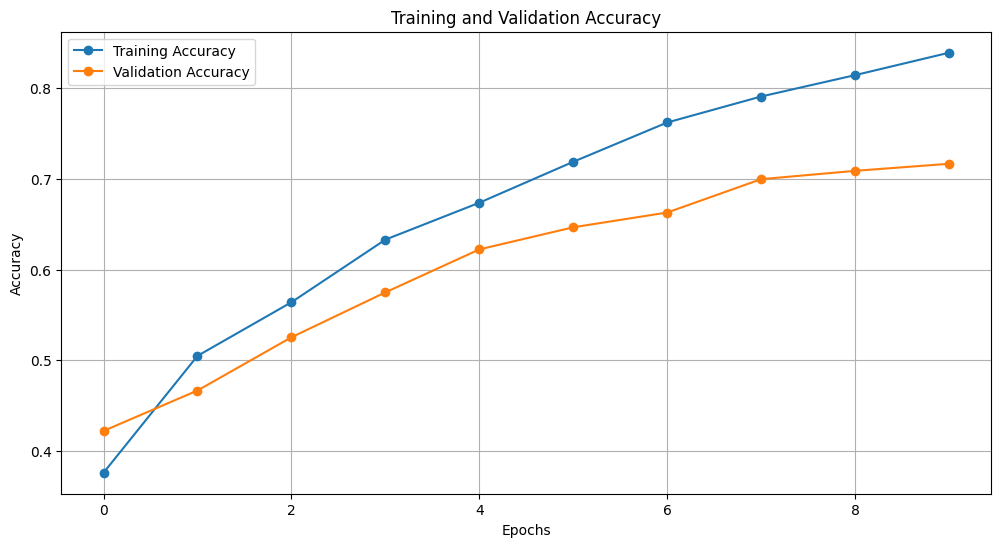

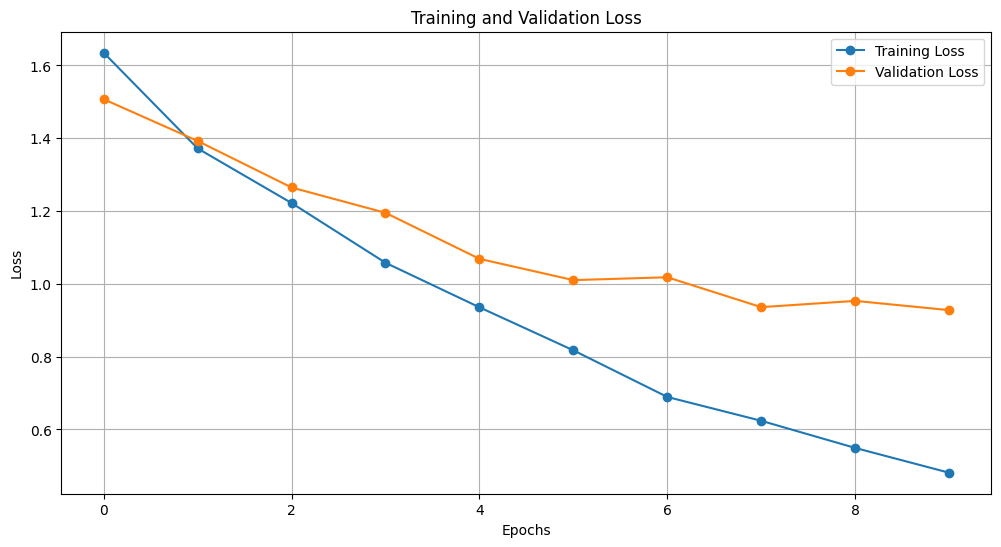

In [74]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [63]:
classification_report(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    target_names=num_to_emotion.values()
)

'              precision    recall  f1-score   support\n\n    Surprise       0.60      0.69      0.64        99\n     Sadness       0.76      0.71      0.74       443\n       Anger       0.56      0.86      0.68       170\n        Fear       0.75      0.91      0.82       189\n   Enjoyment       0.80      0.78      0.79       904\n     Disgust       0.80      0.60      0.69       528\n       Other       0.56      0.60      0.58       497\n\n    accuracy                           0.72      2830\n   macro avg       0.69      0.74      0.71      2830\nweighted avg       0.73      0.72      0.72      2830\n'

In [64]:
best_model.save(r'..\Trâm model\best_bilstm_w2v_model.h5')

In [ ]:
# Load model and make predict
bilstm_w2v = tf.keras.models.load_model(r'..\Trâm model\best_bilstm_w2v_model.h5')
text = 'mình rất vui vẻ'
text = tokenize(text)
text = remove_stopwords(text)
text = np.array([sentence_to_sequence(text, word_index, max_len)])
prediction = np.argmax(bilstm_w2v.predict(text), axis=1)
prediction = num_to_emotion[prediction[0]]
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


'Enjoyment'

In [75]:
# summary of the model
bilstm_w2v.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 100)        │       574,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 50, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 892,405 (3.40 MB)

 Trainable params: 892,403 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Chỉnh lại W2V


In [55]:
def convert_sentence_to_sequence(sentence, word_index, max_len):
    sequence = [word_index.get(word, 0) for word in sentence]  # 0 nếu từ không có trong Word2Vec
    return sequence[:max_len] + [0] * max(0, max_len - len(sequence))  # Padding

In [147]:
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# 1. Chuẩn bị dữ liệu

# Bước 1: Tải mô hình Word2Vec từ file
model = joblib.load('D:/HK5/NLP/UIT-VSMEC-20241212T141641Z-001/word2vec_model.pkl')  # Đường dẫn đến mô hình Word2Vec

# Bước 2: Tạo ma trận embedding
vocab_size = len(model.wv.key_to_index) + 1  # Thêm 1 cho padding token
embedding_dimension = model.vector_size  # Kích thước vector embedding
embedding_matrix = np.zeros((vocab_size, embedding_dimension))

word_index_mapping = {word: index for index, word in enumerate(model.wv.index_to_key, start=1)}
for word, index in word_index_mapping.items():
    embedding_matrix[index] = model.wv[word]

# Định nghĩa độ dài tối đa của câu
max_length = 50  # Có thể thay đổi tùy thuộc vào dữ liệu

# Chuyển đổi tập huấn luyện và kiểm tra thành các sequence
X_train_sequences = np.array([convert_sentence_to_sequence(sentence, word_index_mapping, max_length) for sentence in train_df['Text']])
X_test_sequences = np.array([convert_sentence_to_sequence(sentence, word_index_mapping, max_length) for sentence in test_df['Text']])

# Chuẩn bị nhãn
y_train_labels = to_categorical(train_df['Emotion'].values, num_classes=len(emotion_to_num))
y_test_labels = to_categorical(test_df['Emotion'].values, num_classes=len(emotion_to_num))

# 2. Xây dựng mô hình LSTM
lstm_model = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dimension, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(emotion_to_num), activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# 3. Huấn luyện mô hình
batch_size_value = 34
epochs_value = 10

training_history = lstm_model.fit(
    X_train_sequences, y_train_labels,
    validation_data=(X_test_sequences, y_test_labels),
    batch_size=batch_size_value,
    epochs=epochs_value,
    verbose=1
)

loss_value, accuracy_value = lstm_model.evaluate(X_test_sequences, y_test_labels)
print(f"Test Accuracy: {accuracy_value:.4f}")

predicted_labels = lstm_model.predict(X_test_sequences)
predicted_class_labels = np.argmax(predicted_labels, axis=1)
true_class_labels = np.argmax(y_test_labels, axis=1)

# Đảm bảo rằng num_to_emotion chứa các giá trị là chuỗi
target_names = [str(num_to_emotion[key]) for key in sorted(num_to_emotion.keys())]

print("Classification Report:")
print(classification_report(true_class_labels, predicted_class_labels, target_names=target_names))

# 5. Lưu mô hình
lstm_model.save(folder + '/lstm_cte_model.h5')

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 50, 100)        │       581,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 50, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 50, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,107 (3.88 MB)

 Trainable params: 434,439 (1.66 MB)

 Non-trainable params: 582,668 (2.22 MB)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.2751 - loss: 1.9583 - val_accuracy: 0.4111 - val_loss: 1.6328
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4603 - loss: 1.5140 - val_accuracy: 0.4697 - val_loss: 1.4423
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.4982 - loss: 1.3877 - val_accuracy: 0.4962 - val_loss: 1.3581
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5262 - loss: 1.2963 - val_accuracy: 0.4986 - val_loss: 1.3289
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5679 - loss: 1.2168 - val_accuracy: 0.5380 - val_loss: 1.2403
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5984 - loss: 1.1049 - val_accuracy: 0.5781 - val_loss: 1.1540
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6359 - loss: 1.0212 - val_accuracy: 0.5642 - val_loss: 1.2229
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6640 - loss: 0.9335 - val_acc

Classification Report:
              precision    recall  f1-score   support

    Surprise       0.31      0.77      0.45       104
     Sadness       0.63      0.65      0.64       462
     Disgust       0.63      0.50      0.56       521
        Fear       0.60      0.86      0.71       177
       Other       0.53      0.39      0.45       511
   Enjoyment       0.76      0.67      0.71       906
       Anger       0.50      0.81      0.62       187

    accuracy                           0.61      2868
   macro avg       0.57      0.66      0.59      2868
weighted avg       0.63      0.61      0.61      2868



In [66]:
max_len

50

CT TFIDF

In [ ]:
training_sentences = train_df['Text'].astype(str).tolist()
test_sentences = test_df['Text'].astype(str).tolist()

# Bước 2: Tải mô hình TF-IDF đã lưu
tfidf_vectorizer = joblib.load(r'D:\VSCODE\EmotionsRecognition\Trâm model\tfidf_vectorizer.pkl')  # Đường dẫn đến mô hình TF-IDF đã lưu

# Chuyển đổi dữ liệu thành ma trận TF-IDF
X_train_tfidf = tfidf_vectorizer.transform(training_sentences).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_sentences).toarray()

# Chuẩn bị nhãn
y_train_labels = to_categorical(train_df['Emotion'].values, num_classes=len(emotion_to_num))
y_test_labels = to_categorical(test_df['Emotion'].values, num_classes=len(emotion_to_num))

In [102]:
y_train_labels = to_categorical(train_df['Emotion'].values, num_classes=len(emotion_to_num))
y_test_labels = to_categorical(test_df['Emotion'].values, num_classes=len(emotion_to_num))

In [77]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import joblib  # To load the pre-trained TF-IDF model

# 1. Chuẩn bị dữ liệu
# Ensure that 'Text' columns contain strings and convert them to a list of strings


# 2. Xây dựng mô hình
lstm_model = Sequential([
    Input(shape=(X_train_tfidf.shape[1],)),  # Độ dài của đặc trưng TF-IDF
    Dense(128, activation='relu'),  # Thay vì Embedding, dùng Dense layer
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(emotion_to_num), activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# 3. Huấn luyện mô hình
batch_size_value = 34
epochs_value = 10

training_history = lstm_model.fit(
    X_train_tfidf, y_train_labels,
    validation_data=(X_test_tfidf, y_test_labels),
    batch_size=batch_size_value,
    epochs=epochs_value,
    verbose=1
)

loss_value, accuracy_value = lstm_model.evaluate(X_test_tfidf, y_test_labels)
print(f"Test Accuracy: {accuracy_value:.4f}")

predicted_labels = lstm_model.predict(X_test_tfidf)
predicted_class_labels = np.argmax(predicted_labels, axis=1)
true_class_labels = np.argmax(y_test_labels, axis=1)

# Đảm bảo rằng num_to_emotion chứa các giá trị là chuỗi
target_names = [str(num_to_emotion[key]) for key in sorted(num_to_emotion.keys())]

print("Classification Report:")
print(classification_report(true_class_labels, predicted_class_labels, target_names=target_names))

# 5. Lưu mô hình
lstm_model.save(folder + '/lstm_tfidf_ct_model.h5')

c:\Users\vanhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\vanhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │       625,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 633,863 (2.42 MB)

 Trainable params: 633,863 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2628 - loss: 1.8816 - val_accuracy: 0.5293 - val_loss: 1.4625
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6178 - loss: 1.1561 - val_accuracy: 0.6837 - val_loss: 0.9720
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8119 - loss: 0.6498 - val_accuracy: 0.7148 - val_loss: 0.8378
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8905 - loss: 0.4106 - val_accuracy: 0.7364 - val_loss: 0.7845
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9154 - loss: 0.2981 - val_accuracy: 0.7527 - val_loss: 0.7863
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9454 - loss: 0.2098 - val_accuracy: 0.7516 - val_loss: 0.8307
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9496 - loss: 0.1730 - val_accuracy: 0.7544 - val_loss: 0.8617
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9572 - loss: 0.1389 - val_accuracy: 0.

Classification Report:
              precision    recall  f1-score   support

    Surprise       0.45      0.79      0.57        99
     Sadness       0.84      0.74      0.79       443
       Anger       0.65      0.85      0.74       170
        Fear       0.79      0.90      0.84       189
   Enjoyment       0.85      0.79      0.82       904
     Disgust       0.75      0.71      0.73       528
       Other       0.66      0.64      0.65       497

    accuracy                           0.75      2830
   macro avg       0.71      0.78      0.73      2830
weighted avg       0.77      0.75      0.76      2830



Test TF-IDF

In [105]:
import numpy as np
import joblib  # Ensure you import joblib to load the TF-IDF vectorizer
from tensorflow.keras.models import load_model

# Bước 1: Định nghĩa câu cần kiểm tra
input_sentence = "Chán quá đi tao không biết làm cái này mày ơi :("

# Bước 2: Tiền xử lý câu
# Giả sử bạn có các hàm preprocess như tokenize và remove_stopwords
tokenized_sentence = tokenize(input_sentence)  # Tokenize câu
tokenized_sentence = remove_stopwords(tokenized_sentence)  # Loại bỏ stopwords

# Bước 3: Chuyển đổi danh sách từ thành chuỗi
preprocessed_sentence = ' '.join(tokenized_sentence)
# Bước 4: Tải mô hình TF-IDF đã lưu
# Chuyển đổi câu đã tiền xử lý thành vector TF-IDF
input_tfidf = tfidf_vectorizer.transform([preprocessed_sentence]).toarray()

# Bước 5: Tải mô hình LSTM
model = load_model(folder + '/lstm_tfidf_ct_model.h5')  # Thay thế bằng đường dẫn thực tế

# Bước 6: Dự đoán
prediction = model.predict(input_tfidf)
predicted_class = np.argmax(prediction)

# Bước 7: Hiển thị kết quả
emotion_labels = ["Anger", "Sadness", "Disgust", "Fear", "Surprise", "Enjoyment", "Other"]  # Thay đổi theo nhãn của bạn
print(f"Kết quả dự đoán cho câu '{input_sentence}' là: {emotion_labels[predicted_class]}")
print(f"Các xác suất cảm xúc: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Kết quả dự đoán cho câu 'Chán quá đi tao không biết làm cái này mày ơi :(' là: Sadness
Các xác suất cảm xúc: [[1.9372387e-06 9.9919754e-01 2.7037002e-04 1.4557535e-04 4.5402714e-05
  8.1719125e-05 2.5744154e-04]]


array([[1.9372387e-06, 9.9919754e-01, 2.7037002e-04, 1.4557535e-04,
        4.5402714e-05, 8.1719125e-05, 2.5744154e-04]], dtype=float32)